In [1]:
# Import Needed Modules
import pandas as pd
from prophet import Prophet

# Import the data files
weather_df = pd.read_csv("Resources/Canton_Ohio_Weather.csv")
cfs_df = pd.read_excel("Resources/cfs_data_Canton.xlsx")
reports_df = pd.read_excel("Resources/reported_crime.xlsx")

In [2]:
# Clean and keep: Weather Data
# Columns to keep: dt_iso, temp, feels_like, temp_min, temp_max, humidity, 
# weather_description, rain_1h, snow_1h
# Columns to make: temp_avg (To replace temp_min/temp_max for that hour?)
weather_df = weather_df[['dt_iso','temp','feels_like','temp_min','temp_max',
                         'humidity','weather_description','rain_1h','snow_1h']]

# Create the temp average for the hour
weather_df['temp_avg'] = (weather_df['temp_min'] + weather_df['temp_max'])/2

# Convert dt_iso to datetime and localize
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], 
                                      format='%Y-%m-%d %H:%M:%S %z UTC')
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_convert("America/New_York")

# Create column to link on merge
weather_df['relation'] = weather_df['dt_iso'].dt.strftime("%Y-%m-%d %H:%M:%S")

# Bin the temperature to the nearest multiple of 5
# Example: Rounding 41 to 40 and 44 to 45
weather_df['Temperature Bin'] = weather_df['temp'].apply(lambda x: round(x / 5) * 5)

weather_df.head()

,dt_iso,temp,feels_like,temp_min,temp_max,humidity,weather_description,rain_1h,snow_1h,temp_avg,relation,Temperature Bin
0,2014-12-31 19:00:00-05:00,21.63,9.03,21.60,22.44,42,sky is clear,NaN,NaN,22.02,2014-12-31 19:00:00,20
1,2014-12-31 20:00:00-05:00,21.51,8.91,20.98,22.44,46,sky is clear,NaN,NaN,21.71,2014-12-31 20:00:00,20
2,2014-12-31 21:00:00-05:00,21.51,9.19,20.98,22.44,46,sky is clear,NaN,NaN,21.71,2014-12-31 21:00:00,20
3,2014-12-31 22:00:00-05:00,20.57,7.97,20.52,22.44,48,sky is clear,NaN,NaN,21.48,2014-12-31 22:00:00,20
4,2014-12-31 23:00:00-05:00,20.57,8.02,20.52,21.36,48,sky is clear,NaN,NaN,20.94,2014-12-31 23:00:00,20


In [3]:
# Clean and keep: Calls for Service Data
# Columns to keep: CallType, CreateDatetime
# Create relation column for weather if needed
cfs_df = cfs_df[['CallType','CreateDatetime']]
cfs_df['relation'] = cfs_df['CreateDatetime'].dt.strftime("%Y-%m-%d %H:00:00")

cfs_df.head()

,CallType,CreateDatetime,relation
0,Disturbance,2023-12-22 21:09:34.750,2023-12-22 21:00:00
1,911 Hangup,2023-12-22 21:04:17.120,2023-12-22 21:00:00
2,911 Hangup,2023-12-22 20:44:22.477,2023-12-22 20:00:00
3,911 Hangup,2023-12-22 20:41:46.953,2023-12-22 20:00:00
4,Theft,2023-12-22 20:27:56.443,2023-12-22 20:00:00


In [4]:
# Clean and keep: Reported Crime
# Columns to keep: dordate, tor, offense, QOL_category, crimetype, crimeagainst, 
# day_of_week
reports_df = reports_df[['dordate','tor', 'ti1', 'offense', 'QOL_category', 
                         'crimetype', 'crimeagainst', 'day_of_week']]

# Rename columns
reports_df = reports_df.rename(columns={'dordate':'Report Date',
                                        'tor':'Report Time',
                                        'ti1':'Incident Time'})

# Keep only rows that have a full time of report time
reports_df = reports_df.loc[reports_df['Report Time'].str.len() >=8]

# Combine Date and time for relation column for weather if needed
reports_df['relation'] = reports_df['Report Date'] + pd.to_timedelta(reports_df['Report Time'])
reports_df['relation'] = reports_df['relation'].dt.strftime("%Y-%m-%d %H:00:00")

# Display
reports_df.head()

,Report Date,Report Time,Incident Time,offense,QOL_category,crimetype,crimeagainst,day_of_week,relation
0,2024-01-02,17:04:10,16:55:00,MENACING,Menacing,Violent,Person,Tuesday,2024-01-02 17:00:00
1,2024-01-02,09:40:00,17:00:00,BURGLARY,Burglary,Property,Property,Tuesday,2024-01-02 09:00:00
2,2024-01-02,14:28:13,14:15:00,REPORT REQUIRED ON LOST/STOLEN FIREARM,Weapons Violations,Society,Society,Tuesday,2024-01-02 14:00:00
3,2024-01-02,02:55:24,02:30:00,CRIMINAL DAMAGING / ENDANGERING,Damaging,Property,Property,Tuesday,2024-01-02 02:00:00
4,2024-01-02,07:36:33,07:26:00,VANDALISM,Damaging,Property,Property,Tuesday,2024-01-02 07:00:00


In [5]:
""" Start focus analysis: Overdose
When do ODs occur the most?
What are the stats leading up to prediction model?
"""
weekday_order = ["Sunday", "Monday", "Tuesday", 
                 "Wednesday", "Thursday", "Friday", "Saturday"]

# Merge CFS data with weather
overdose_df = pd.merge(cfs_df, weather_df, on='relation',how='inner')

# Keep only Overdose data
overdose_df = overdose_df.loc[overdose_df['CallType'].str.contains("Overdose")]

# Create additional fields for year, month, day etc.
# This is a personal preference for easier reading when grouping and column
# the name can be called rather than the function. It is also easier in this
# case to export the data if needed.
# Alternative: overdose_df.groupby(overdose_df['CreateDatetime'].dt.year).agg({"CreateDatetime":"count"})
overdose_df['Date'] = overdose_df["CreateDatetime"].dt.strftime("%m/%d/%Y")
overdose_df['year'] = overdose_df['CreateDatetime'].dt.year
overdose_df['month'] = overdose_df['CreateDatetime'].dt.month
overdose_df['weekday'] = overdose_df['CreateDatetime'].dt.weekday
overdose_df['weekday_name'] = overdose_df['CreateDatetime'].dt.strftime('%A')

# Help sort weekday name by assigning weekday_name as Categorical order (Pandas, n.d.)
overdose_df['weekday_name'] = pd.Categorical(overdose_df['weekday_name'], 
                                             categories=weekday_order, 
                                             ordered=True)
overdose_df['month_name'] = overdose_df['CreateDatetime'].dt.month_name(locale = 'English')
overdose_df['hour'] = overdose_df['CreateDatetime'].dt.hour
# overdose_df = overdose_df.set_index("CreateDatetime")

overdose_df.head()

,CallType,CreateDatetime,relation,dt_iso,temp,feels_like,temp_min,temp_max,humidity,weather_description,...,snow_1h,temp_avg,Temperature Bin,Date,year,month,weekday,weekday_name,month_name,hour
2227,Overdose,2023-12-07 01:24:08.460,2023-12-07 01:00:00,2023-12-07 01:00:00-05:00,32.43,23.05,31.24,33.98,86,overcast clouds,...,NaN,32.61,30,12/07/2023,2023,12,3,Thursday,December,1
3655,Overdose,2023-11-28 20:07:01.843,2023-11-28 20:00:00,2023-11-28 20:00:00-05:00,21.33,13.77,19.96,22.96,76,broken clouds,...,NaN,21.46,20,11/28/2023,2023,11,1,Tuesday,November,20
4894,Overdose,2023-11-21 08:20:30.627,2023-11-21 08:00:00,2023-11-21 08:00:00-05:00,39.72,31.50,37.92,42.10,91,light rain,...,NaN,40.01,40,11/21/2023,2023,11,1,Tuesday,November,8
4895,Overdose,2023-11-21 08:20:30.627,2023-11-21 08:00:00,2023-11-21 08:00:00-05:00,39.72,31.50,37.92,42.10,91,mist,...,NaN,40.01,40,11/21/2023,2023,11,1,Tuesday,November,8
5793,Overdose,2023-11-16 01:39:23.803,2023-11-16 01:00:00,2023-11-16 01:00:00-05:00,41.83,39.96,37.33,46.09,57,sky is clear,...,NaN,41.71,40,11/16/2023,2023,11,3,Thursday,November,1


In [6]:
# How many overdoses occur yearly?
overdose_df.groupby("year").agg({"CallType":"count"}).reset_index()

,year,CallType
0,2019,77
1,2020,64
2,2021,114
3,2022,149
4,2023,112


In [7]:
# 2022 was the year with most overdoses. What months in 2022 had the most?
od_df_2022 = overdose_df.loc[overdose_df['year'] == 2022]
od_df_sort_2022 = od_df_2022.groupby("month").agg({"CallType":"count"}).sort_values("CallType",ascending=False)
od_df_sort_2022 = od_df_sort_2022.rename(columns={"CallType":"Total Overdose per Month"})
od_df_sort_2022

,Total Overdose per Month
month,
6,18
9,18
7,16
5,15
11,14
4,13
3,12
10,10
12,10


<Axes: xlabel='weekday_name'>

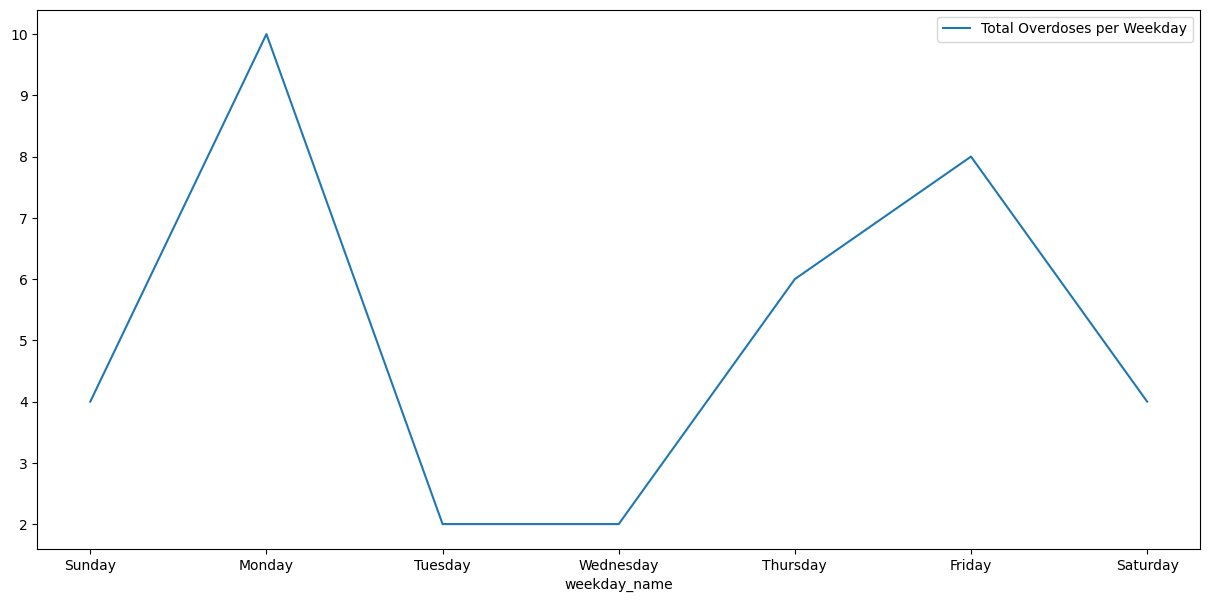

In [8]:
# 2022: June and September were the most overdose months.
# What days of the week did the overdoses occur the most in these two months?
od_df_2022_weekday = od_df_2022.loc[(od_df_2022["month"] == 6) | (od_df_2022["month"] == 9)]
od_df_2022_weekday = od_df_2022_weekday.groupby("weekday_name").agg({"CallType":"count"})
od_df_2022_weekday = od_df_2022_weekday.rename(columns={"weekday_name":"Weekday","CallType":"Total Overdoses per Weekday"})
od_df_2022_weekday.plot(figsize=[15,7])

In [9]:
# June and September 2022 showed the most overdoses on Mondays in the two months
# What hours did the overdoses occur the most on Mondays in the timeframe?
od_df_2022_hours = od_df_2022.loc[(od_df_2022["month"] == 6) | (od_df_2022["month"] == 9)]
od_df_2022_hours = od_df_2022_hours.loc[od_df_2022_hours["weekday_name"] == "Monday"]
od_df_2022_hours = od_df_2022_hours.groupby("hour").agg({"CallType":"count"})
od_df_2022_hours = od_df_2022_hours.rename(columns={"CallType":"Overdoses per Hour"})
od_df_2022_hours.sort_values("Overdoses per Hour", ascending=False)

,Overdoses per Hour
hour,
3,3
12,2
15,2
1,1
16,1
19,1


In [10]:
# Gather how many total overdoses by month
overdose_df.groupby("month").agg({"month":"count"})

,month
month,
1,41
2,34
3,42
4,42
5,52
6,48
7,55
8,35
9,44


<Axes: xlabel='month'>

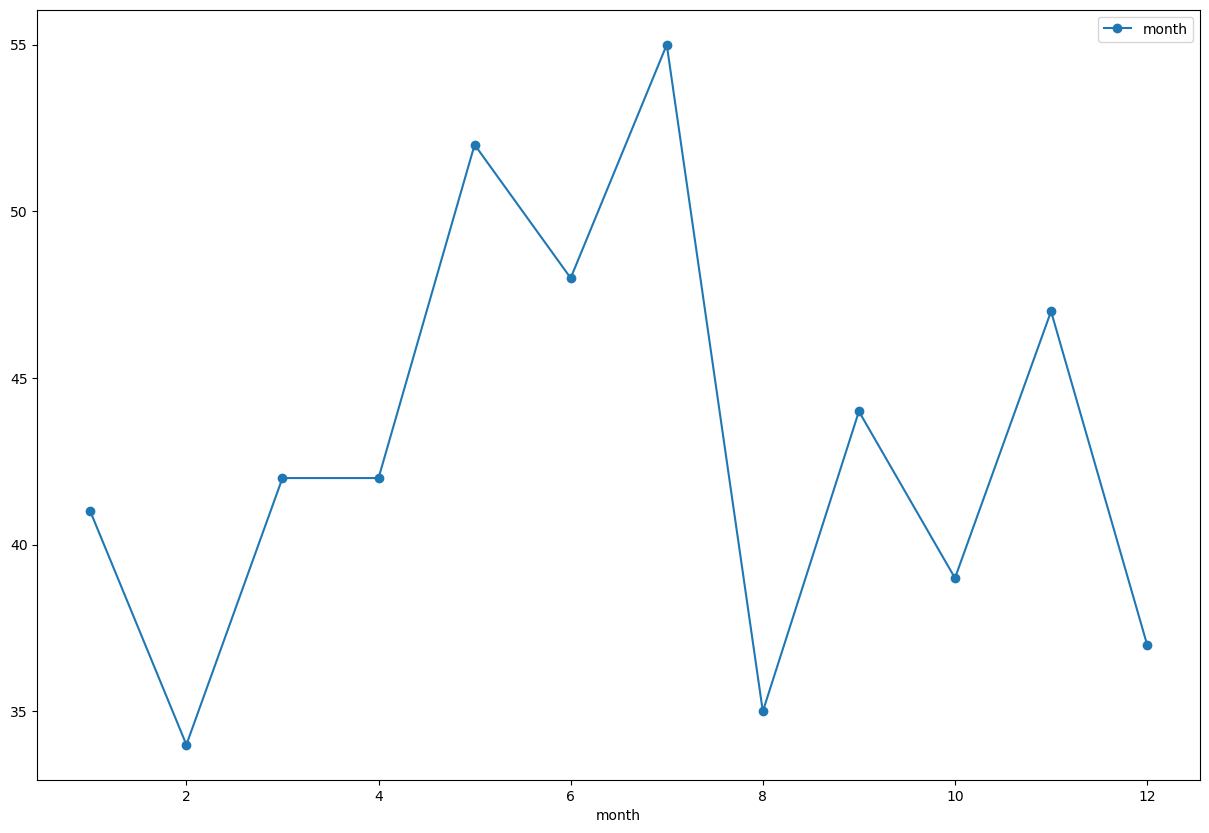

In [11]:
# What is the most common months of overdoses over the entire dataset?
overdose_df.groupby("month").agg({"month":"count"}).plot(marker='o',figsize=[15,10])

In [12]:
# What is the most common hours of overdoses over the entire dataset?
overdose_hours = overdose_df.groupby("hour").agg({"CallType":"count"})
overdose_hours.sort_values("CallType", ascending=False)

,CallType
hour,
1,33
21,30
23,29
20,29
3,28
16,28
2,27
19,27
18,27


<Axes: xlabel='hour'>

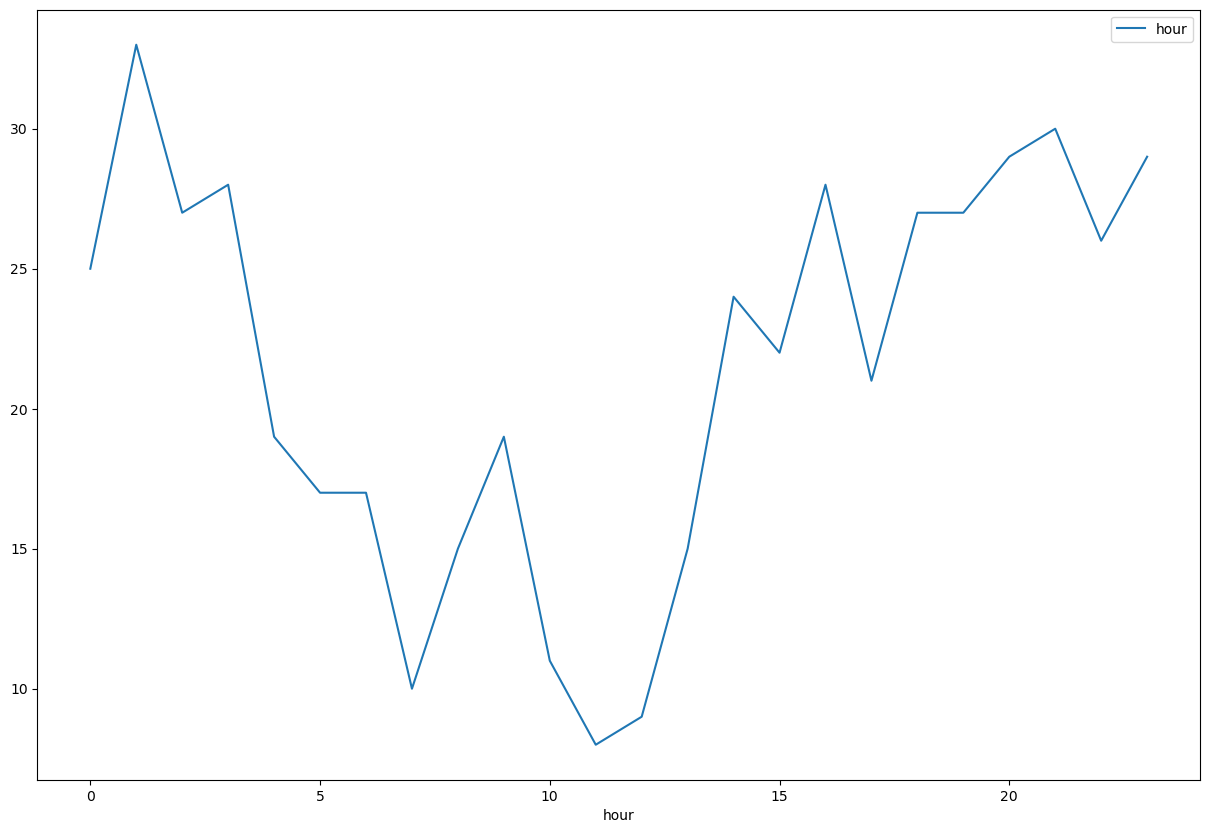

In [13]:
# What is the most common hours of overdoses over the entire dataset? Plotted
overdose_df.groupby("hour").agg({"hour":"count"}).plot(figsize=[15,10])


<Axes: xlabel='weekday_name'>

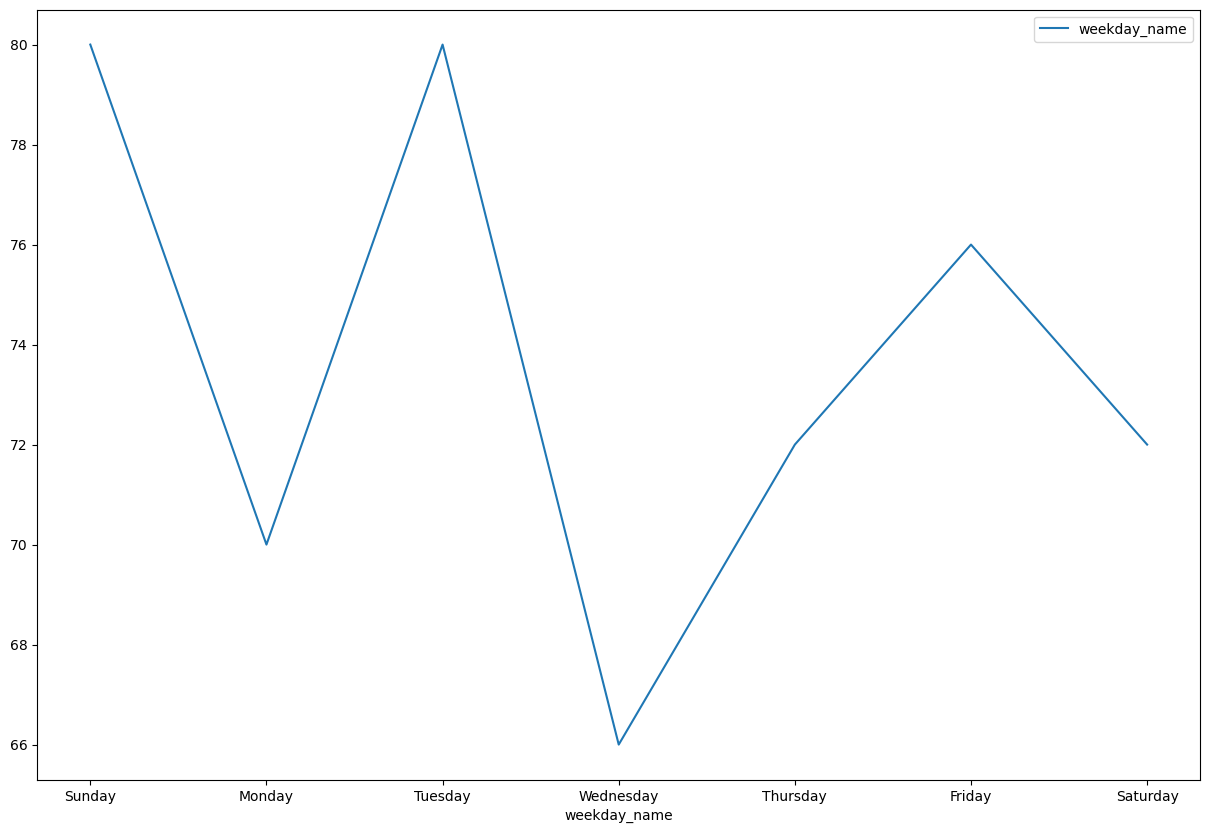

In [14]:
# What is the most common days of the week of overdoses over the entire dataset?
overdose_df.groupby("weekday_name").agg({"weekday_name":"count"}).plot(figsize=[15,10])

In [15]:
# Predict future overdoses
od_prediction = overdose_df.groupby(overdose_df['Date']).agg({"CallType":"count"}).reset_index()
od_prediction['Date'] = pd.to_datetime(od_prediction['Date'])
od_prediction = od_prediction.sort_values("Date")
prophet_df = od_prediction.reset_index(drop=True)

prophet_df.head()

,Date,CallType
0,2019-01-02,1
1,2019-01-05,1
2,2019-01-06,2
3,2019-01-14,1
4,2019-01-19,2


In [16]:
# Resample the dataset to fill missing days.  Set missing days as 0 occurrence 
# for more accurate results.
future_df = overdose_df.groupby(overdose_df['Date']).agg({"CallType":"count"}).reset_index()
future_df['Date'] = pd.to_datetime(future_df['Date'])
future_df = future_df.set_index("Date")
future_df_resampled = future_df.resample('D').sum().fillna(0).reset_index()

future_df_resampled.head(10)

,Date,CallType
0,2019-01-02,1
1,2019-01-03,0
2,2019-01-04,0
3,2019-01-05,1
4,2019-01-06,2
5,2019-01-07,0
6,2019-01-08,0
7,2019-01-09,0
8,2019-01-10,0
9,2019-01-11,0


In [17]:
# Set up prophet with datetime as ds and count of overdose per day as y
prophet_df = future_df_resampled.reset_index(drop=True)
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.dropna()
prophet_df.tail()
m = Prophet()
m.fit(prophet_df)

# Make future timeframe 30 days out
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)

10:27:26 - cmdstanpy - INFO - Chain [1] start processing
10:27:27 - cmdstanpy - INFO - Chain [1] done processing


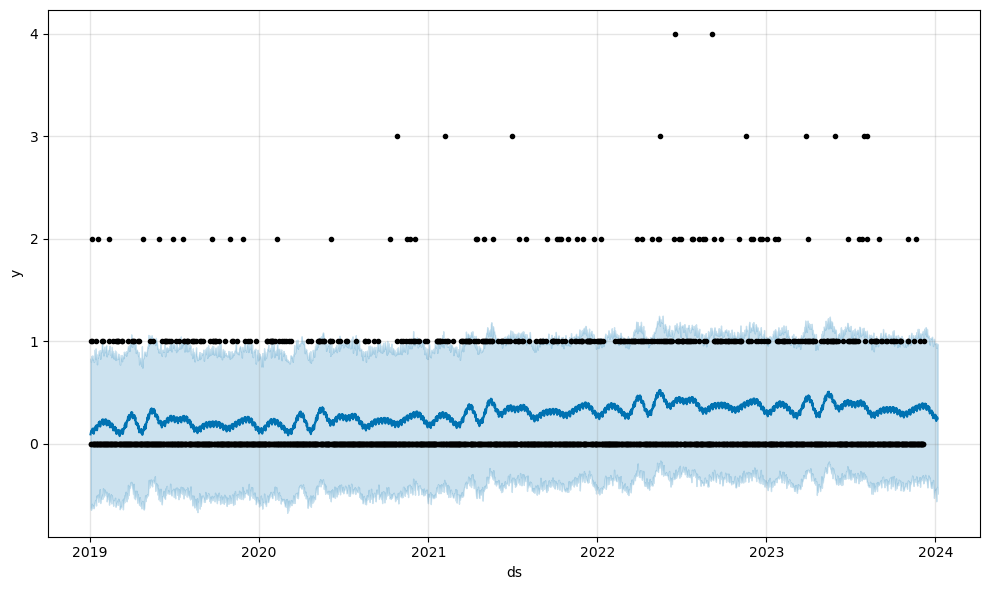

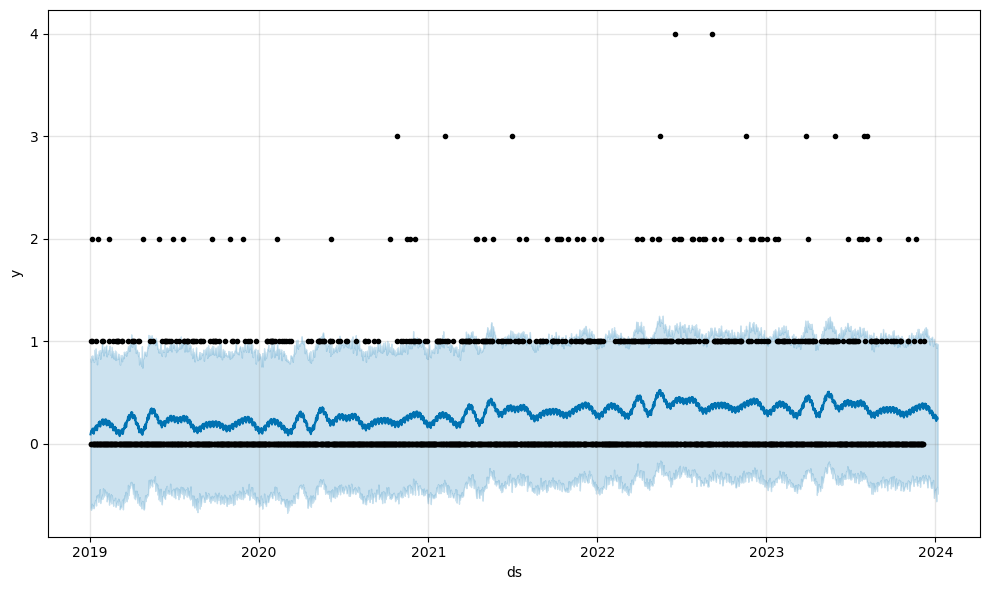

In [18]:
# Plot the forecast
m.plot(forecast, figsize=[10,6])

<Axes: >

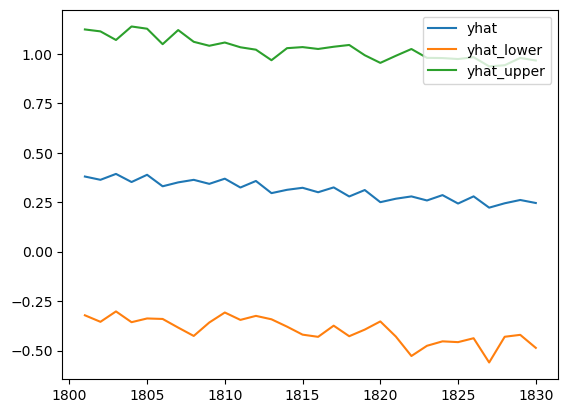

In [19]:
# Plot the future hats
forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-30:,:].plot()

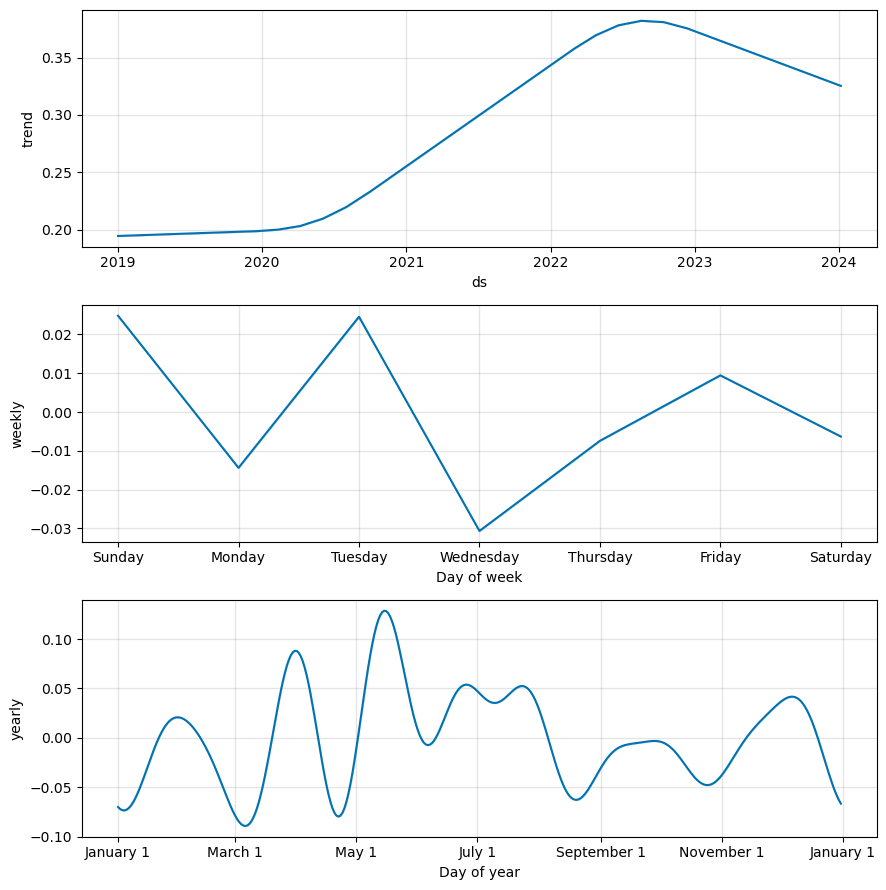

In [20]:
forecast = forecast.reset_index(drop=True)
fig2 = m.plot_components(forecast)

<Axes: xlabel='Date'>

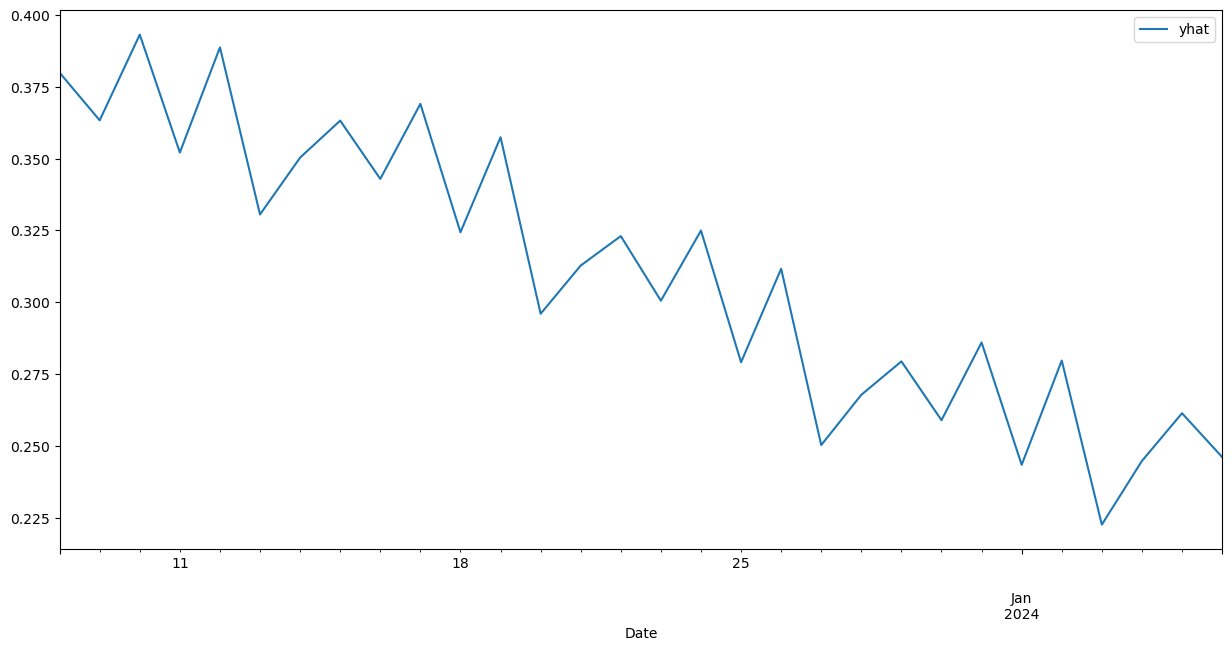

In [21]:
test = forecast.iloc[-30:, :][['ds','yhat']].set_index('ds')
test.plot(figsize=[15,7],
          xlabel='Date')